versão inicial fortemente baseada em
https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/,
artigo original: https://arxiv.org/abs/1511.06434

bibliotecas utilizadas:

In [1]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten

from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import IPython.display
import PIL.Image

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input

import matplotlib.pyplot as plt

import random

import tensorflow_datasets as tfds

from imgaug import augmenters as iaa

import os

d:\Users\felip\anaconda3\envs\TCC_20220914\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Constantes:

In [2]:
genWidth = 7
genHeight = 7
genDepth = 64
noiseDim = 100
genFCOutputDim = 512
imgChannels = 1
imgWidth = 28
imgHeight = 28

leakyReluAlpha = 0.2
discFCOutputDim = 512

initLr = 2e-4
ganEpochs = 25
classifierEpochs = 8
batchSize = 128

nClasses = 10
datasetName = 'mnist'
#carrega dataset
dataset, info = tfds.load(name = datasetName, with_info=True, as_supervised=True, data_dir='D:/Documentos/UNB/TCC/tfDatasets')

datasetName += '_unbalanced'
#validação cruzada
kFold = 5
currentFold = 3

minClassInstances = 250     #número de instâncias mínimo da classe menos representada

Funções helper para apresentação de imagens e dados de treinamento

In [3]:
def concatArray(a, n):
    d = []
    for j in range(a.shape[1]):
        for i in range(n):
            d.append(a[i][j])
    d = np.array(d)
    d = np.reshape(d, (a.shape[1],a.shape[2]*n))
    return d

In [4]:
#mostrar input/output
def showOutputAsImg(out, n = 20):
  IPython.display.display(PIL.Image.fromarray(concatArray(out,n)).resize(size=(100*n,100)))

In [5]:
def plotLoss(losses, clear=True):
    if(clear):
        plt.clf()
    for loss in losses:
        plt.plot(loss[0], label=loss[1])
    plt.legend()
    plt.show()

In [6]:
def verifiedFolder(folderPath):
    createdFolder = folderPath
    if('.' in createdFolder.split('/')[-1]):
        createdFolder = '/'.join(createdFolder.split('/')[:-1])
    if not os.path.exists(createdFolder):
        os.makedirs(createdFolder)
    return folderPath

Cria model geradora com keras functional API

In [7]:
def makeGenerator():
    genInput = keras.Input(shape=(100,), name = 'genInput_randomDistribution')

    # cria camada de entrada, com noiseDim entradas, saída de tamanho sCOutputDim, e ativação relu
    # entrada -> tamanho escolhido
    genX = layers.Dense(genFCOutputDim, activation='relu')(genInput)
    genX = layers.BatchNormalization()(genX)

    # cria camada que converte saída da primeira camada para o número de nós necessário na entrada
    # das camadas convolucionais
    genX = layers.Dense(units=genWidth*genHeight*genDepth, activation='relu')(genX)
    genX = layers.BatchNormalization()(genX)
    labelOutput = layers.Dense(nClasses, activation='sigmoid', name='genOutput_label')(genX)

    # Faz reshape para dimensões espaciais desejadas
    genX = layers.Reshape((genWidth, genHeight, genDepth))(genX)

    # convolução transposta (genWidth,genHeight,genDepth =/ strides)
    genX = layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(genX)
    genX = layers.BatchNormalization(axis=-1)(genX)

    # camada convolucional que tem como output a imagem de saída
    # tanh é usado pois é necessária saída de espaço limitado
    genOutput = layers.Conv2DTranspose(filters=imgChannels, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh', name = 'genOutput_img')(genX)

    generator = keras.Model(inputs = genInput, outputs = [genOutput, labelOutput], name = 'generator')
    
    keras.utils.plot_model(
        generator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/generator/fold_' + str(currentFold) + '.png')
    )
    return generator

Cria model CGAN geradora com keras functional API

In [8]:
def makeCGenerator():
    cgenNoiseInput = keras.Input(shape=(100,), name = 'genInput_randomDistribution')
    cgenLabelInput = keras.Input(shape=(nClasses,), name = 'genInput_label')

    cgenX = layers.concatenate([cgenNoiseInput, cgenLabelInput])

    # cria camada de entrada, com noiseDim entradas, saída de tamanho sCOutputDim, e ativação relu
    # entrada -> tamanho escolhido
    cgenX = layers.Dense(genFCOutputDim, activation='relu')(cgenX)
    cgenX = layers.BatchNormalization()(cgenX)

    # cria camada que converte saída da primeira camada para o número de nós necessário na entrada
    # das camadas convolucionais
    cgenX = layers.Dense(units=genWidth*genHeight*genDepth, activation='relu')(cgenX)
    cgenX = layers.BatchNormalization()(cgenX)

    # Faz reshape para dimensões espaciais desejadas
    cgenX = layers.Reshape((genWidth, genHeight, genDepth))(cgenX)

    # convolução transposta (genWidth,genHeight,genDepth =/ strides)
    cgenX = layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(cgenX)
    cgenX = layers.BatchNormalization(axis=-1)(cgenX)

    # camada convolucional que tem como output a imagem de saída
    # tanh é usado pois é necessária saída de espaço limitado
    cgenOutput = layers.Conv2DTranspose(filters=imgChannels, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh', name = 'genOutput_img')(cgenX)

    cgenerator = keras.Model(inputs = [cgenNoiseInput, cgenLabelInput], outputs = cgenOutput, name = 'cgenerator')

    keras.utils.plot_model(
        cgenerator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/cgenerator/flod_' + str(currentFold) + '.png')
    )
    return cgenerator

Cria model discriminadora com functional API

In [9]:
def makeDiscriminator():
    discInput = keras.Input(shape=(imgWidth, imgHeight, imgChannels), name = 'discInput_img')

    # primeira camada convolucional, recebe formato das imagens
    discX = layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', strides=(2,2))(discInput)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)

    # segunda camada convolucional.
    discX = layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', strides=(2,2))(discX)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)
    discX = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(discX)
    # camada densa
    discX = layers.Flatten()(discX)
    discX = layers.Dropout(0.2)(discX)

    labelInput = keras.Input(shape=(nClasses,), name = 'discInput_label')
    discX = layers.concatenate([discX, labelInput])
    discX = layers.Dense(discFCOutputDim)(discX)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)

    # nó de output, sigmoid->mapear em 0 ou 1
    discOutput = layers.Dense(1, activation='sigmoid', name = 'discOutput_realVSfake')(discX)

    discriminator = keras.Model(inputs = [discInput, labelInput], outputs = discOutput, name = 'discriminator')

    keras.utils.plot_model(
        discriminator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/discriminator/fold_' + str(currentFold) + '.png')
    )
    return discriminator

Preparando dados

In [10]:
def loadIntoArray(dataset):
    npI = dataset.as_numpy_iterator()
    imgs = []
    lbls = []
    for d in npI:
        imgs.append(d[0])
        lbls.append([int(d[1] == n) for n in range(nClasses)])
    imgs = np.array(imgs)
    imgs = (imgs.astype("float") - 127.5) / 127.5
    lbls = np.array(lbls)
    return imgs, lbls

In [11]:
def oversampledata(imgs, lbls):
    nclasses = len(lbls[0])
    sortedImgs = [[] for i in range(nclasses)]
    sortedLbls = [[] for i in range(nclasses)]
    count = [0]*nclasses
    for i in range(len(lbls)):
        id = lbls[i].argmax()
        sortedImgs[id].append(imgs[i])
        sortedLbls[id].append(lbls[i])
        count[id] +=1

    maxcount = np.max(count)
    outImgs = []
    outLbls = []

    for i in range(nclasses):
        reps = int(maxcount/count[i])+1
        outImgs += (sortedImgs[i]*reps)[:maxcount]
        outLbls += (sortedLbls[i]*reps)[:maxcount]

    return shuffle(np.array(outImgs), np.array(outLbls))

In [12]:
imgs1, lbls1 = loadIntoArray(dataset['train'])
imgs2, lbls2 = loadIntoArray(dataset['test'])

imgs = np.concatenate((imgs1, imgs2))
lbls = np.concatenate((lbls1, lbls2))

totalEntries = imgs.shape[0]

'''imgs = imgs[:round(totalEntries/10)]
lbls = lbls[:round(totalEntries/10)]
totalEntries = imgs.shape[0]'''
n = int(np.floor(totalEntries/kFold))

trainImgs = imgs[:currentFold*n]
trainLbls = lbls[:currentFold*n]
testImgs = imgs[currentFold*n:(currentFold + 1)*n]
testLbls = lbls[currentFold*n:(currentFold + 1)*n]
trainImgs = np.concatenate((trainImgs, imgs[(currentFold + 1)*n:]))
trainLbls = np.concatenate((trainLbls, lbls[(currentFold + 1)*n:]))

#gerando versão desbalanceada do banco de dados
tempCounter = [0]*10
for i in range(len(trainLbls)):
     for j in range(10):
        if(trainLbls[i][j] == 1):
            tempCounter[j] += 1
maxClassInstances = np.max(tempCounter)
coeff = (maxClassInstances - minClassInstances)/9

unbalancedImgs = []
unbalancedLbls = []
counter = [0]*10
for i in range(len(trainLbls)):
     for j in range(10):
        if(trainLbls[i][j] == 1 and counter[j] <= (j*coeff + minClassInstances)):
            unbalancedImgs.append(trainImgs[i])
            unbalancedLbls.append(trainLbls[i])
            counter[j] += 1
unbalancedImgs = np.array(unbalancedImgs)
unbalancedLbls = np.array(unbalancedLbls)

oversampledImgs, oversampledLbls = oversampledata(unbalancedImgs, unbalancedLbls)

In [34]:
c = [0]*10
cx = 0
for i in unbalancedLbls:
    c[i.argmax()] += 1
    if(i.argmax() == 7):
        cx+=1
print(c)
print([i/len(unbalancedLbls) for i in c])
print(len(unbalancedLbls))

[251, 920, 1590, 2259, 2929, 3598, 4268, 4937, 5498, 5593]
[0.00788242313852338, 0.02889175014916936, 0.04993248123606444, 0.07094180824671042, 0.0919825393336055, 0.11299186634425148, 0.13403259743114657, 0.15504192444179254, 0.17265961121753604, 0.17564299846120027]
31843


compilando gerador e gan


In [13]:
def compileGAN():
    optDiscr = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
    ganDiscriminator = makeDiscriminator()
    ganDiscriminator.compile(loss='binary_crossentropy', optimizer=optDiscr)

    ganGenerator = makeGenerator()
    ganDiscriminator.trainable = False
    ganInput = Input(shape=(100,))
    ganOutput = ganDiscriminator(ganGenerator(ganInput))
    gan = Model(ganInput, ganOutput)

    optGan = Adam(learning_rate=initLr, beta_1=0.5, decay=initLr/ganEpochs)
    gan.compile(loss= 'binary_crossentropy', optimizer=optGan)
    
    keras.utils.plot_model(
        gan, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/gan/fold_' + str(currentFold) + '.png')
    )
    return ganGenerator,ganDiscriminator, gan

compilando gerador condicional e cgan

In [14]:
def compileCGAN():
    optDiscr = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
    cganDiscriminator = makeDiscriminator()
    cganDiscriminator.compile(loss='binary_crossentropy', optimizer=optDiscr)

    cganGenerator = makeCGenerator()
    cganDiscriminator.trainable = False
    cganNoiseInput = Input(shape=(100,))
    cganLabelInput = Input(shape=(nClasses,))
    cganOutput = cganDiscriminator([cganGenerator([cganNoiseInput, cganLabelInput]), cganLabelInput])
    cgan = Model((cganNoiseInput, cganLabelInput), cganOutput)

    optcGan = Adam(learning_rate=initLr, beta_1=0.5, decay=initLr/ganEpochs)
    cgan.compile(loss= 'binary_crossentropy', optimizer=optcGan)
    
    keras.utils.plot_model(
        cgan, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/cgan/fold_' + str(currentFold) + '.png')
    )
    
    return cganGenerator,cganDiscriminator, cgan

treinamento GAN


In [15]:
def trainGAN(imgs, lbls, generator, discriminator, gan):
  benchNoise = np.random.uniform(-1,1, size=(256,100))
  genLossHist = []
  discLossHist = []

  for epoch in range(ganEpochs):
    nBatches = int(imgs.shape[0]/batchSize)
    for i in range(nBatches):
      imgBatch = imgs[i*batchSize:(i+1)*batchSize]
      labelBatch = lbls[i*batchSize:(i+1)*batchSize]
      genInput = np.random.uniform(-1,1,size=(batchSize,100))
      genImgOutput, genLabelOutput = generator.predict(genInput, verbose=0)

      XImg = np.concatenate((imgBatch, genImgOutput))
      XLabel = np.concatenate((labelBatch, genLabelOutput))
      y = ([1] * batchSize) + ([0] * batchSize)
      y = np.reshape(y, (-1,))
      (XImg, XLabel, y) = shuffle(XImg, XLabel, y)
      
      discLoss = discriminator.train_on_batch([XImg,XLabel], y)
      
      genTrainNoise = np.random.uniform(-1,1,size=(batchSize,100))
      gentrainLbls = [1]*batchSize
      gentrainLbls = np.reshape(gentrainLbls, (-1,))
      ganLoss = gan.train_on_batch(genTrainNoise,gentrainLbls)
      if i == nBatches-1:
        discLossHist.append(discLoss)
        genLossHist.append(ganLoss)
        IPython.display.clear_output(True)
        print("Epoch " + str(epoch) + "\nGAN (generator training) loss: " + str(ganLoss) + "\ndiscriminator loss: " + str(discLoss))
        images, labels = generator.predict(benchNoise)
        out = ((images * 127.5) + 127.5).astype('uint8')
        showOutputAsImg(out)
        print([str(a.argmax()) + ' ' for a in labels[:20]])
        plotLoss([[genLossHist, 'generator loss'],[discLossHist, 'discriminator loss']])
    if(epoch%5 == 0 or epoch == ganEpochs-1):
      generator.save(verifiedFolder('modelSaves/' + datasetName + '/gen/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      discriminator.save(verifiedFolder('modelSaves/' + datasetName + '/disc/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      gan.save(verifiedFolder('modelSaves/' + datasetName + '/gan/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))

treinamento CGAN

In [16]:
def trainCGAN(imgs, lbls, generator, discriminator, cgan):
  cdiscLossHist = []
  cgenLossHist = []

  #noise e labels de benchmark
  benchNoise = np.random.uniform(-1,1, size=(256,100))
  benchLabels = np.random.randint(0,nClasses, size = (256))
  for i in range(20):
    benchLabels[i] = int(i/2)

  benchLabels = np.array([[1 if i == bl else 0 for i in range(nClasses)] for bl in benchLabels], dtype='float32')

  for epoch in range(ganEpochs):
    nBatches = int(imgs.shape[0]/batchSize)
    for i in range(nBatches):
      imgBatch = imgs[i*batchSize:(i+1)*batchSize]
      labelBatch = lbls[i*batchSize:(i+1)*batchSize]
      genInput = np.random.uniform(-1,1,size=(batchSize,100))
      labelInput = np.random.randint(0,nClasses, size = (batchSize))
      labelInput = np.array([[1 if i == li else 0 for i in range(nClasses)] for li in labelInput], dtype='float32')
      genImgOutput = generator.predict([genInput, labelInput], verbose=0)

      XImg = np.concatenate((imgBatch, genImgOutput))
      XLabel = np.concatenate((labelBatch, labelInput))
      y = ([1] * batchSize) + ([0] * batchSize)
      y = np.reshape(y, (-1,))
      (XImg, XLabel, y) = shuffle(XImg, XLabel, y)
      
      discLoss = discriminator.train_on_batch([XImg,XLabel], y)
      
      genTrainNoise = np.random.uniform(-1,1,size=(batchSize,100))
      genTrainClasses = np.random.randint(0,nClasses, size = (batchSize))
      genTrainClasses = np.array([[1 if i == c else 0 for i in range(nClasses)] for c in genTrainClasses], dtype='float32')
      gentrainLbls = [1]*batchSize 
      gentrainLbls = np.reshape(gentrainLbls, (-1,))
      ganLoss = cgan.train_on_batch([genTrainNoise, genTrainClasses],gentrainLbls)

      if i == nBatches-1:
        cdiscLossHist.append(discLoss)
        cgenLossHist.append(ganLoss)
        IPython.display.clear_output(True)
        print("Epoch " + str(epoch) + "\nGAN (generator training) loss: " + str(ganLoss) + "\ndiscriminator loss: " + str(discLoss))
        images = generator.predict([benchNoise, benchLabels])
        out = ((images * 127.5) + 127.5).astype('uint8')
        showOutputAsImg(out)
        print([str(a.argmax()) + ' ' for a in benchLabels[:20]])
        plotLoss([[cgenLossHist, 'generator loss'],[cdiscLossHist, 'discriminator loss']])
    if(epoch%5 == 0 or epoch == ganEpochs-1):
      generator.save(verifiedFolder('modelSaves/' + datasetName + '/cgen/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      discriminator.save(verifiedFolder('modelSaves/' + datasetName + '/cdisc/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      cgan.save(verifiedFolder('modelSaves/' + datasetName + '/cgan/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))

Treinando GAN

Epoch 24
GAN (generator training) loss: 1.3732004165649414
discriminator loss: 0.4453800618648529


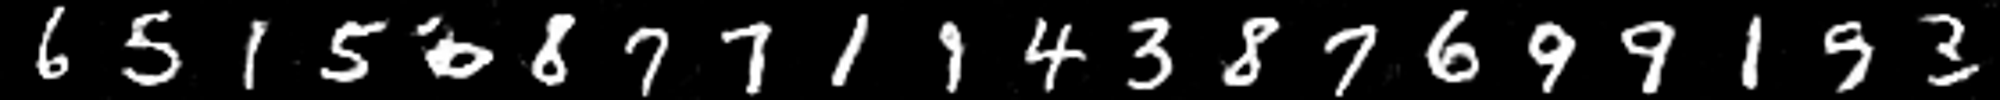

['6 ', '5 ', '1 ', '5 ', '6 ', '8 ', '7 ', '7 ', '1 ', '9 ', '4 ', '3 ', '8 ', '7 ', '6 ', '9 ', '9 ', '1 ', '9 ', '3 ']


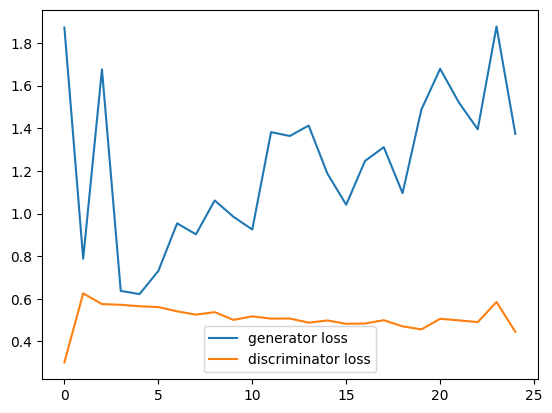

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gen/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gen/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/disc/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/disc/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gan/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gan/training/fold_3/epoch24\assets


In [17]:
gen, disc, gan = compileGAN()
trainGAN(oversampledImgs, oversampledLbls, gen, disc, gan)

In [18]:
gen.save(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))
disc.save(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))
gan.save(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))
'''
gen = load_model(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))
disc = load_model(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))
gan = load_model(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))'''

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gen/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gen/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/disc/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/disc/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gan/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/gan/fold_3\assets


"\ngen = load_model(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))\ndisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))\ngan = load_model(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))"

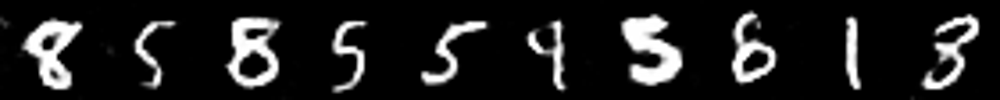

[[1.9579656e-14 2.6440877e-19 1.3736323e-16 5.3908030e-26 2.6084116e-20
  5.8839793e-20 4.9800767e-16 5.2037244e-25 1.0000000e+00 2.7256182e-11]
 [6.3186969e-16 1.2756604e-14 6.4207705e-13 7.8173617e-22 1.5599124e-15
  1.0000000e+00 1.2105242e-11 1.8750176e-19 1.2418770e-10 2.2264335e-09]
 [2.5597851e-13 2.0559724e-15 1.6120613e-20 1.4196260e-11 1.0754454e-11
  7.1598522e-02 3.2160327e-14 3.5376593e-16 9.9948007e-01 1.4462203e-23]
 [7.7890482e-16 1.4605246e-15 1.0352050e-11 3.7385540e-15 1.1286355e-12
  9.9998856e-01 2.7733617e-14 3.1296137e-18 1.6983656e-16 5.2382739e-04]
 [1.3401709e-15 3.4252240e-11 2.9587363e-12 2.4778919e-18 3.1865672e-13
  1.0000000e+00 3.5227238e-13 7.0623622e-17 6.1064947e-15 1.7565227e-10]
 [8.1446579e-08 1.1251982e-09 5.9705496e-14 5.8425720e-15 3.6886802e-01
  2.8407341e-17 2.0007476e-20 2.0177809e-10 1.8980359e-15 7.0093036e-01]
 [3.0788001e-08 9.0573556e-11 1.9806546e-12 1.0957627e-01 2.1745199e-11
  9.3594933e-01 1.0227297e-03 7.6362397e-08 2.0796227e-09 

In [19]:
noise = np.random.uniform(-1,1, size=(nClasses,100))
images, lbls = gen.predict(noise)
out = ((images * 127.5) + 127.5).astype('uint8')
showOutputAsImg(out,nClasses)
print(lbls[:nClasses])

Treinando CGAN

Epoch 24
GAN (generator training) loss: 2.683809280395508
discriminator loss: 0.31603187322616577


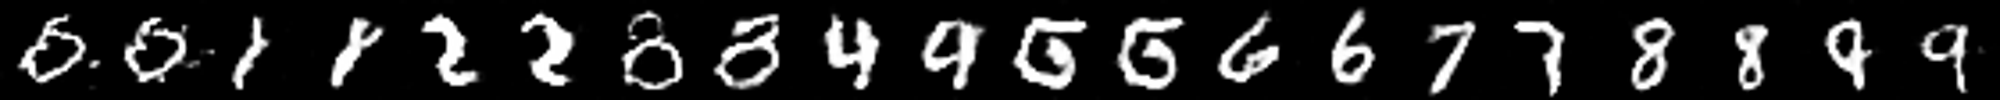

['0 ', '0 ', '1 ', '1 ', '2 ', '2 ', '3 ', '3 ', '4 ', '4 ', '5 ', '5 ', '6 ', '6 ', '7 ', '7 ', '8 ', '8 ', '9 ', '9 ']


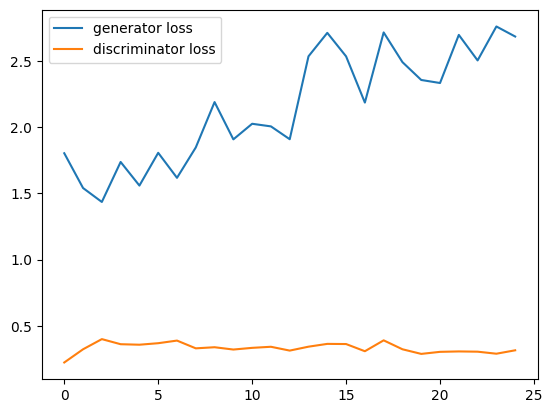

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgen/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgen/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cdisc/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cdisc/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgan/training/fold_3/epoch24\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgan/training/fold_3/epoch24\assets


In [20]:
cgen, cdisc, cgan = compileCGAN()
trainCGAN(unbalancedImgs, unbalancedLbls, cgen, cdisc, cgan)

In [21]:
cgen.save(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))
cdisc.save(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))
cgan.save(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))
'''
cgen = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))
cdisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))
cgan = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))'''

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgen/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgen/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cdisc/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cdisc/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgan/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/cgan/fold_3\assets


"\ncgen = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))\ncdisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))\ncgan = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))"

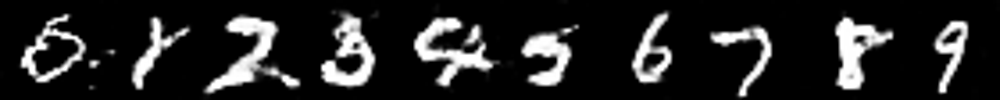

In [22]:
noise = np.random.uniform(-1,1, size=(nClasses,100))
labels = np.array([[1 if i == j else 0 for i in range(nClasses)] for j in range(nClasses)], dtype='float32')
images = cgen.predict([noise, labels])
out = ((images * 127.5) + 127.5).astype('uint8')
showOutputAsImg(out,nClasses)

Criando classificador símples para testes

In [23]:
def initClassifier(load = False):
    if(load):
        classifier = load_model("modelSaves/" + datasetName + "/classifier/init/fold_" + str(currentFold))
        return classifier
    else:
        classInput = keras.Input(shape=(imgWidth, imgHeight, imgChannels), name = 'classInput')
        # primeira camada convolucional, recebe formato das imagens
        classX = layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', strides=(2,2))(classInput)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # segunda camada convolucional.
        classX = layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', strides=(2,2))(classX)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # camada densa
        classX = layers.Flatten()(classX)
        classX = layers.Dense(discFCOutputDim)(classX)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # camada de output, chassificador one hot
        classOutput = layers.Dense(nClasses, activation='sigmoid', name='genOutput_label')(classX)

        classifier = keras.Model(inputs = classInput, outputs = classOutput, name = 'classifier')

        keras.utils.plot_model(
            classifier, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/classifier/fold_' + str(currentFold) + '.png')
        )

        optClass = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
        classifier.compile(loss='binary_crossentropy', optimizer=optClass)
        classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/init/fold_' + str(currentFold)))
        
        return classifier

initClassifier()

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/init/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/init/fold_3\assets


Funções helper para testes

In [24]:
def generateData(nEntries):
    print("started data generation")
    genInput = np.random.uniform(-1,1,size=(nEntries,100))
    genImg, genLbl = gen.predict(genInput, verbose=0)
    print("finished data generation")
    return np.array(genImg[:nEntries]), np.array(genLbl[:nEntries])

In [25]:
def generateDataCGAN(nEntries):
    print("started data generation")
    genInput = np.random.uniform(-1,1,size=(nEntries,100))
    genLabelInput = np.random.randint(0,nClasses, size = (nEntries))
    genLabelInput = np.array([[1 if i == li else 0 for i in range(nClasses)] for li in genLabelInput], dtype='float32')
    genImages = cgen.predict([genInput, genLabelInput])
    print("finished data generation")
    return genImages, genLabelInput

In [26]:
def generateBalancedData(initImgs, initLbls, mult = 1):
    print("started data generation")
    nClasses = len(initLbls[0])

    frequencies = [0]*nClasses

    for l in initLbls:
        frequencies[l.argmax()] += 1

    maxcount = max(frequencies)*mult

    necessaryLbls = np.empty((0,10))
    for c in range(nClasses):
        diff = (maxcount - frequencies[c])
        newitems = np.tile(np.array([1 if i == c else 0 for i in range(nClasses)]), diff).reshape((diff,nClasses))
        necessaryLbls = np.concatenate((necessaryLbls, newitems)) 

    necessaryLbls = np.array(necessaryLbls, dtype='float32')
    noise = np.random.uniform(-1,1, size=(len(necessaryLbls),100))

    genImages = cgen.predict([noise, necessaryLbls])

    imgs = np.concatenate((initImgs, genImages))
    lbls = np.concatenate((initLbls, necessaryLbls))
    (imgs, lbls) = shuffle(imgs, lbls)
    
    print("finished data generation")
    return imgs, lbls

In [27]:
def runTest(classifier):
    classOutput = classifier.predict(testImgs, verbose=0)
    classOutput = [[int(np.argmax(o) == i) for i in range(nClasses)] for o in classOutput]
    print(classification_report(testLbls, classOutput))
    print('auroc score: ' + str(roc_auc_score(testLbls, classOutput)))

In [28]:
def trainClassifier(imgs, lbls, trainName, extraEpochs = 1, aug = False):
    classifier = initClassifier(True)
    classLossHist = []
    '''seq = iaa.Sequential([
        #iaa.Crop(px=(0, 5)),
        #iaa.Fliplr(0.5),
        iaa.GaussianBlur(sigma=(0, 2.0))
    ])'''

    nBatches = int(imgs.shape[0]/batchSize)
    for epoch in range(round(classifierEpochs * extraEpochs)):
        for i in range(nBatches):
            imgBatch = imgs[i*batchSize:(i+1)*batchSize]
            labelBatch = lbls[i*batchSize:(i+1)*batchSize]

            '''if(aug):
                imgBatch = seq(images=imgBatch)'''
            
            classLoss = classifier.train_on_batch(imgBatch,labelBatch)
            
            if i == nBatches-1:
                classLossHist.append(classLoss)
                IPython.display.clear_output(True)
                print("Epoch " + str(epoch) + "\nclassifier loss: " + str(classLoss))
                plotLoss([[classLossHist, 'classifier loss']])
        if(epoch % 5 == 0 or epoch == classifierEpochs * extraEpochs - 1):
            classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/' + trainName + '/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
    classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/' + trainName + '/fold_' + str(currentFold)))
    return classifier

Treinando classificador com dados do dataset diretamente

Epoch 7
classifier loss: 0.0033509067725390196


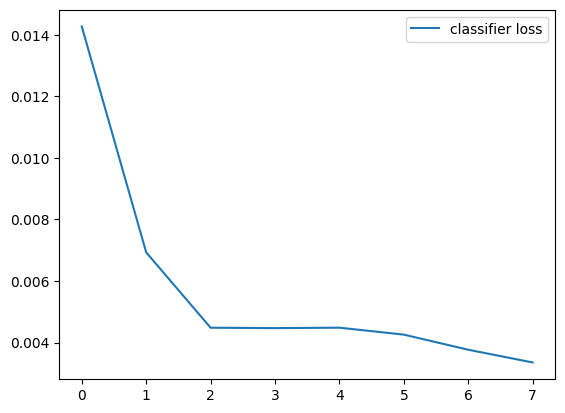

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/none/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/none/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/none/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/none/fold_3\assets


              precision    recall  f1-score   support

           0       1.00      0.55      0.71      1374
           1       1.00      0.82      0.90      1601
           2       0.99      0.74      0.85      1392
           3       0.99      0.84      0.91      1485
           4       1.00      0.76      0.86      1345
           5       0.98      0.91      0.94      1213
           6       0.90      0.99      0.94      1422
           7       0.95      0.93      0.94      1476
           8       0.58      0.99      0.73      1327
           9       0.61      0.99      0.76      1365

   micro avg       0.85      0.85      0.85     14000
   macro avg       0.90      0.85      0.86     14000
weighted avg       0.90      0.85      0.86     14000
 samples avg       0.85      0.85      0.85     14000

auroc score: 0.9181420540359087


In [29]:
classifier = trainClassifier(unbalancedImgs, unbalancedLbls, 'none')
runTest(classifier)

Treinando classificador com dados aumentados com algoritmos classicos

Epoch 7
classifier loss: 0.0014451410388574004


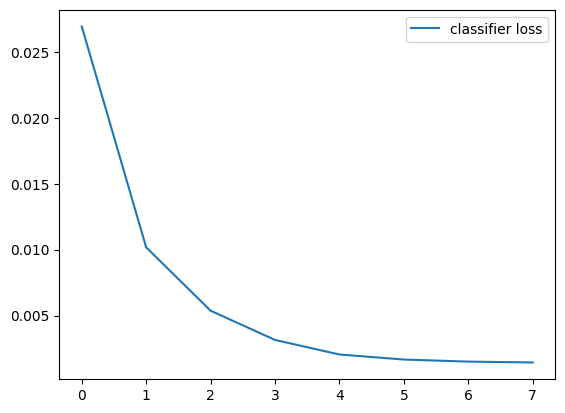

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/classic/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/classic/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/classic/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/classic/fold_3\assets


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1374
           1       0.99      0.99      0.99      1601
           2       0.98      0.98      0.98      1392
           3       0.99      0.98      0.98      1485
           4       0.99      0.98      0.98      1345
           5       0.98      0.98      0.98      1213
           6       0.98      1.00      0.99      1422
           7       0.97      0.99      0.98      1476
           8       0.95      0.99      0.97      1327
           9       0.98      0.98      0.98      1365

   micro avg       0.98      0.98      0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000
 samples avg       0.98      0.98      0.98     14000

auroc score: 0.9898824401746351


In [30]:
classifier = trainClassifier(oversampledImgs, oversampledLbls, 'classic')
runTest(classifier)

Treinando classificador apenas com dados gerados pela GAN

Epoch 7
classifier loss: 0.030167022719979286


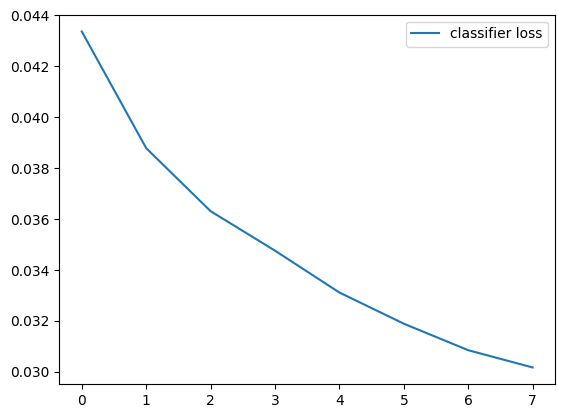

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/gan/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/gan/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/gan/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/gan/fold_3\assets


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1374
           1       0.97      0.97      0.97      1601
           2       0.94      0.89      0.91      1392
           3       0.89      0.95      0.92      1485
           4       0.92      0.94      0.93      1345
           5       0.88      0.92      0.90      1213
           6       0.95      0.96      0.96      1422
           7       0.94      0.90      0.92      1476
           8       0.92      0.88      0.90      1327
           9       0.85      0.93      0.89      1365

   micro avg       0.93      0.93      0.93     14000
   macro avg       0.93      0.93      0.93     14000
weighted avg       0.93      0.93      0.93     14000
 samples avg       0.93      0.93      0.93     14000

auroc score: 0.9585257901393611


In [31]:
genImgOutput, genLabelOutput = generateData(unbalancedImgs.shape[0]*10)
classifier = trainClassifier(genImgOutput, genLabelOutput, 'gan')
runTest(classifier)

Treinando classificador apenas com dados gerados pela CGAN

Epoch 7
classifier loss: 6.574934445779945e-07


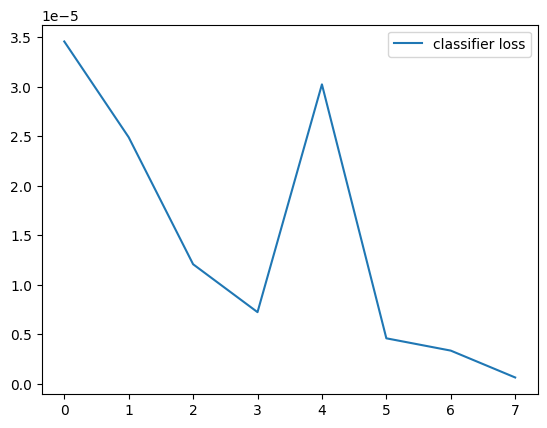

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/cgan/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/cgan/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/cgan/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/cgan/fold_3\assets


              precision    recall  f1-score   support

           0       0.99      0.49      0.66      1374
           1       0.95      0.88      0.91      1601
           2       0.93      0.39      0.54      1392
           3       0.81      0.71      0.76      1485
           4       0.94      0.91      0.92      1345
           5       0.67      0.89      0.76      1213
           6       0.68      0.98      0.81      1422
           7       0.83      0.94      0.88      1476
           8       0.64      0.87      0.74      1327
           9       0.80      0.90      0.85      1365

   micro avg       0.80      0.80      0.80     14000
   macro avg       0.82      0.80      0.78     14000
weighted avg       0.83      0.80      0.79     14000
 samples avg       0.80      0.80      0.80     14000

auroc score: 0.8861803742779294


In [32]:
cgenImgOutput, cgenLabelOutput = generateDataCGAN(unbalancedImgs.shape[0]*10)
classifier = trainClassifier(cgenImgOutput, cgenLabelOutput, 'cgan')
runTest(classifier)

Epoch 7
classifier loss: 0.004198075737804174


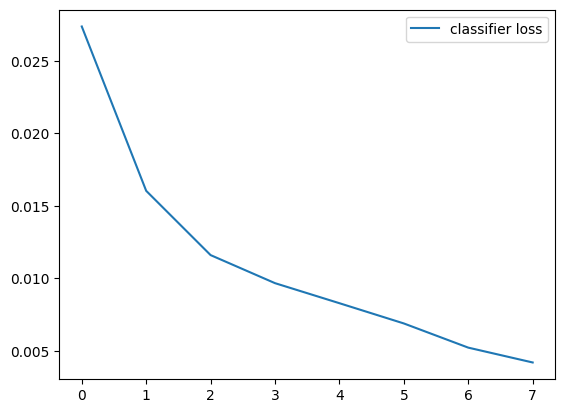

INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/original+cgan_rebalanced/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/original+cgan_rebalanced/training/fold_3/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/original+cgan_rebalanced/fold_3\assets


INFO:tensorflow:Assets written to: modelSaves/mnist_unbalanced/classifier/original+cgan_rebalanced/fold_3\assets


              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1374
           1       0.99      0.98      0.99      1601
           2       0.98      0.97      0.97      1392
           3       0.99      0.96      0.97      1485
           4       0.98      0.97      0.98      1345
           5       0.98      0.97      0.98      1213
           6       0.97      0.99      0.98      1422
           7       0.96      0.99      0.97      1476
           8       0.94      0.98      0.96      1327
           9       0.94      0.99      0.97      1365

   micro avg       0.97      0.97      0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000
 samples avg       0.97      0.97      0.97     14000

auroc score: 0.9851694032026863


In [33]:
cgenImgOutput, cgenLabelOutput = generateBalancedData(unbalancedImgs, unbalancedLbls)
classifier = trainClassifier(cgenImgOutput, cgenLabelOutput, 'original+cgan_rebalanced')
runTest(classifier)